# Notebook TESTING lazyloading of AMPS domain 02 RAW output 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

import gcsfs
from tqdm import tqdm
import fsspec

xr.set_options(display_style="html");
# xr.show_versions()

# Dask Startup

In [5]:
# xr.show_versions()

In [6]:
## A chunk of code to start dask cluster
from dask.distributed import Client, progress
from dask_gateway import Gateway
gateway = Gateway()

In [27]:
if gateway.list_clusters():
    cluster_name = gateway.list_clusters()[0].name
    cluster = gateway.connect(cluster_name)
    print(f"Connecting to pre-existing cluster with {len(cluster.scheduler_info['workers'])} workers.")
else:
    cluster = gateway.new_cluster() 
    cluster.adapt(minimum=2, maximum=12)
    print("Starting up and connecting to new cluster.")

cluster
# cluster.scheduler_info

Starting up and connecting to new cluster.


In [28]:
client = cluster.get_client()
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.01a581a3d595460eb6560b82e6f3f366 Dashboard: /services/dask-gateway/clusters/prod.01a581a3d595460eb6560b82e6f3f366/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## quick test of lazy loading Bedmachine from GCP

In [29]:
# import gcsfs
# import xarray as xr

# gcs = gcsfs.GCSFileSystem()
# url = 'gs://ldeo-glaciology/bedmachine/BedMachineAntarctica_2019-11-05_v01.nc'  
# openfile = gcs.open(url, mode='rb') 
# ds = xr.open_dataset(openfile, chunks=3000)
# ds['firn'].

In [30]:
# # ds['firn'].plot()

# ds['firn'].mean().compute()

### setup runtime parameters

In [31]:
gcsdir = 'gs://ldeo-glaciology'
ampsdir = 'AMPS'
amps_ver = 'WRF_24'
domain = 'domain_02'
filepattern = 'wrfout_d02_20191231*'


In [32]:
# pattern = 'gs://ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-20161225*'
pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)
print(pattern)

gs://ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_20191231*


### list the netcdf files

In [33]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)

In [34]:
NCs = fs.glob(pattern)
print(f"Total of {len(NCs)} wrf files.\n")
print(NCs[0])

Total of 8 wrf files.

ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f003.nc


In [35]:
NCs_urls = ['https://storage.googleapis.com/' + x + '#mode=bytes' for x in NCs]
print(NCs_urls)

['https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f003.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f006.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f009.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123100_f012.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123112_f003.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123112_f006.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123112_f009.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_02/wrfout_d02_2019123112_f012.nc#mode=bytes']


### a single URL

In [16]:
ds = xr.open_dataset(NCs_urls[0], engine='netcdf4', chunks={'south_north': -1, 'west_east': -1})

In [17]:
print(type(ds.T2.data))
print(ds.T2.chunks)

<class 'dask.array.core.Array'>
((1,), (786,), (834,))


In [18]:
ds.T2


<xarray.DataArray 'T2' (Time: 1, south_north: 786, west_east: 834)>
dask.array<open_dataset-fdfe4a2d384757d0f5283c64fd7aab11T2, shape=(1, 786, 834), dtype=float32, chunksize=(1, 786, 834), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 786, 834), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 786, 834), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

In [21]:
ds.T2.mean().compute()

<xarray.DataArray 'T2' ()>
array(267.80524, dtype=float32)

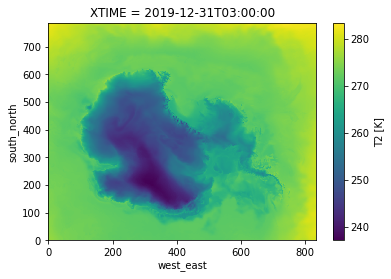

In [22]:
ds.T2.plot()

### make WRF times CF-compliant

In [41]:
ds.XTIME

<xarray.DataArray 'XTIME' (Time: 1)>
dask.array<open_dataset-fdfe4a2d384757d0f5283c64fd7aab11XTIME, shape=(1,), dtype=datetime64[ns], chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time
Attributes:
    FieldType:    104
    MemoryOrder:  0  
    description:  minutes since 2019-12-31 00:00:00
    stagger:

In [42]:
time = ds.variables['XTIME']
print(time.values)

['2019-12-31T03:00:00.000000000']


In [43]:
from netCDF4 import Dataset, num2date

vtimes = num2date(time[:])

TypeError: num2date() takes at least 2 positional arguments (1 given)

### Loop through list of URLs

In [44]:
url = 'gs://' + NCs[0]# + '#mode=bytes'
with  fsspec.open(url, mode='rb')  as openfile:  
    ds2 = xr.open_dataset(openfile, engine='h5netcdf', 
                         chunks={'south_north': 200, 'west_east': 200, 'Time': -1}).load()
    print(ds.variables['XTIME'].values)
    
for i in tqdm(range(1, len(NCs))):  
    url = 'gs://' + NCs[i]# + '#mode=bytes'
    with  fsspec.open(url, mode='rb')  as openfile:  
        temp = xr.open_dataset(openfile, engine='h5netcdf', 
                               chunks={'south_north': 200, 'west_east': 200, 'Time': -1}).load()
        print(temp.variables['XTIME'].values)
        
#     ds2 = xr.concat([ds,temp],'Time')
    
# print(ds.nbytes / 1e9)
# print(ds.XTIME.values)
# ds

ValueError: I/O operation on closed file.

In [39]:
ds.T2

<xarray.DataArray 'T2' (Time: 1, south_north: 786, west_east: 834)>
dask.array<open_dataset-fdfe4a2d384757d0f5283c64fd7aab11T2, shape=(1, 786, 834), dtype=float32, chunksize=(1, 786, 834), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 786, 834), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 786, 834), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

In [38]:
# ds.T2.mean(dim='Time').plot()
t2 = ds.T2.mean().compute()


### Alternatively using `open_mfdatasets`

Build list of URLs to public data in the bucket

In [ ]:
# url = 'https://storage.googleapis.com/ldeo-glaciology/bedmachine/BedMachineAntarctica_2019-11-05_v01.nc#mode=bytes'  
# ds = xr.open_dataset(url, engine='netcdf4', chunks=3000)
# ds

In [ ]:
# xr.open_mfdataset(NCs_urls, parallel=True)
# ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', chunks={'time': 1})

# ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', parallel=True, concat_dim='Time',combine='by_coords')
# #                         chunks={'XLAT': -1})#, 'lat': 168, 'lon': 150}

ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', parallel=True, decode_cf=False,
                       concat_dim="Time", data_vars='minimal', coords='minimal', compat='override')

### pre-process to deal with time

In [14]:
### GENERIC
def preprocessing(ds): 
    return ds.expand_dims(dim='Time')

### DROP NON TIME COORDS
def non_time_coords(ds):
    return [v for v in ds.data_vars
            if 'Time' not in ds[v].dims]

def drop_non_essential_vars_pop(ds):
    return ds.drop(non_time_coords(ds))   

### TEST ADDING TIME
def add_time_dim(xda):
    from datetime import datetime
    
    xda = xda.expand_dims(Time = [datetime.now()])
    return xda

In [16]:
ds = xr.open_mfdataset(NCs_urls, preprocess = add_time_dim)

# # this runs almost instantly
# ds = xr.open_mfdataset(NCs_urls, decode_times=False, chunks={'Time': 1},
#                        preprocess=drop_non_essential_vars_pop, decode_cf=False)

# ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', parallel=True,
#                            concat_dim='Time',combine='by_coords', preprocess = preprocessing)

In [25]:
print(ds['T2'].shape)
print(ds.var)
ds['T2']

(4, 1, 786, 834)
<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:                (Time: 1, bottom_top: 60, bottom_top_stag: 61, soil_layers_stag: 4, south_north: 786, south_north_stag: 787, time: 4, west_east: 834, west_east_stag: 835)
Coordinates:
  * time                   (time) datetime64[ns] 2021-03-17T13:40:25.476966 ....
    XLAT                   (Time, south_north, west_east) float32 dask.array<chunksize=(1, 786, 834), meta=np.ndarray>
    XLONG                  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 786, 834), meta=np.ndarray>
    XTIME                  (time, Time) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    XLAT_U                 (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 786, 835), meta=np.ndarray>
    XLONG_U                (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 786, 835), meta=np.ndarray>
    XLAT_V               

<xarray.DataArray 'T2' (time: 4, Time: 1, south_north: 786, west_east: 834)>
dask.array<concatenate, shape=(4, 1, 786, 834), dtype=float32, chunksize=(1, 1, 786, 834), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-03-17T13:40:25.476966 ... 2021-03-17T...
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 786, 834), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 786, 834), meta=np.ndarray>
    XTIME    (time, Time) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

## Quick overview plot

(array([  15592.,   78557.,  181523.,  131461.,  130657.,  151870.,
         222569., 1144622.,  458279.,  106966.]),
 array([237.12848, 241.7745 , 246.42053, 251.06656, 255.71259, 260.3586 ,
        265.00464, 269.65067, 274.2967 , 278.94272, 283.58875],
       dtype=float32),
 <BarContainer object of 10 artists>)

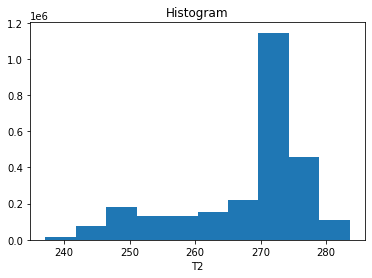

In [17]:
ds['T2'].mean(dim='Time').plot()

### wrf-python

In [ ]:
import wrf
from netCDF4 import Dataset

nc = Dataset(NCs_urls[0:2])



In [ ]:
from wrf import  combine_files
# import netCDF4 as nc
# ncfile = nc.MFDataset(NCs_urls)
T2 = combine_files(nc, timeidx="ALL_TIMES")#, method= "join", meta="False")

In [ ]:
print(zip(*NCs_urls[0:2]))

In [ ]:
nc

In [ ]:
t2 = wrf.getvar(nc, 'T2', timeidx=wrf.ALL_TIMES)
# t2 = wrf.getvar(nc, 'T2', timeidx=2) # extract 3rd time instance (t=2) - slow....
t2

In [ ]:
t2.plot()

In [ ]:
import matplotlib
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import cartopy.feature as cfe
import cartopy.crs as crs

# select one time instance if you have retrieved ALL_TIMES
# t2 = t2.isel(Time=1)

# Get the latitude and longitude points (use original data, rather than any processed data)
lats, lons = wrf.latlon_coords(t2)

# Get the cartopy mapping object (use original data, rather than any processed data)
cart_proj = wrf.get_cartopy(t2)

# Create a figure
fig = plt.figure(figsize=(12,9))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Add coastlines
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(cfe.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', 
                                       '50m', linewidth=1.0, edgecolor='k', facecolor='none') )

# Plot contours
plt.contourf(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(t2), 10, 
                transform=crs.PlateCarree(), cmap=get_cmap("Spectral"))

# Add a color bar
cbar = plt.colorbar(ax=ax, shrink=.62)
cbar.set_label(t2.units)

# Set the map limits.  Not really necessary, but used for demonstration.
ax.set_xlim(wrf.cartopy_xlim(t2))
ax.set_ylim(wrf.cartopy_ylim(t2))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title(t2.description+'\n'+str(t2.Time.values))

print('')

In [ ]:
from wrf import getvar, ALL_TIMES

# Creating a simple test list with three timesteps
wrflist = [Dataset(NCs_urls[0]),
           Dataset(NCs_urls[1]),
           Dataset(NCs_urls[2])]

# Extract the 'P' variable for all times
p_cat = getvar(wrflist, "T2", timeidx=ALL_TIMES, method="cat")

print(p_cat)

In [ ]:
p_cat.plot()

### SALEM

In [ ]:
import salem

## Test write to zarr

In [ ]:
outdir = os.path.join(gcsdir, ampsdir, amps_ver, domain, 'zarr-cf/')
# fs.glob(outdir)
fs.ls(outdir)

In [ ]:
import json

with open('secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)

amps_mapper = fsspec.get_mapper(outdir + 'test_20161225-cf.zarr', mode='ab',
                            token=token)
# ds.to_zarr(amps_mapper, mode='w');

## Close your cluster, be a good denizen.

In [ ]:
cluster.shutdown()